In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Anti-backlash test data

In [46]:
def average_test_repetitions(df, groupby):
    data = []
    grouped = df.groupby(groupby)

    for name, group in grouped:
        group = group.drop(groupby, axis=1)
        group.index = group.index - group.index[0]

        old_len = len(group)
        group = group.resample('0.5ms').mean()
        group = group.interpolate(method='time')
        # print(f'test {name} resampled from {old_len} to {len(group)} samples')

        data.append(group.values)

    # get consistent length
    min_len = min([len(d) for d in data])
    data = [d[:min_len] for d in data]
    # print(f'setting everything to {min_len} samples')

    # average data using numpy
    data_mean = np.mean(np.array(data), axis=0)

    new_columns = df.columns.drop(groupby)
    mean_df = pd.DataFrame(data_mean, columns=new_columns)

    # smooth data
    mean_df = mean_df.rolling(window=100, center=True).mean()
    mean_df = mean_df.bfill().ffill()

    return mean_df


class actuator_test_data:
    def __init__(self, configuration='...'):
        self.configuration = configuration
        self.torque_ramps = {}
        self.speed_ramps = {}
        self.runin_tests = []

        
    def add_test_moment(self, phase, files):
        torque_ramp_files = [f for f in files if 'torqueramp' in f]
        speed_ramp_files = [f for f in files if 'speedramp' in f]
        
        if torque_ramp_files:
            self.add_torque_ramps(phase, torque_ramp_files)
        
        for file in speed_ramp_files:
            self.add_speed_ramp(phase, file)

    def add_torque_ramps(self, name, files):
        torque_ramps = []
        for filename in files:
            df_raw = pd.read_csv(filename)
            print(f'{filename} loaded\t {list(df_raw.columns)}')

            df = pd.DataFrame()
            df['Time [s]'] = df_raw['TIME']
            df['Motor Torque [Nm]'] = df_raw['TORQUE']
            df['Deflection [deg]'] = df_raw['POSITION'] * 360
            df['Desired Torque [Nm]'] = df_raw['CONTROL_TORQUE']
            df['Q_current/5'] = df_raw['Q_CURRENT']/5
            df['test_nr'] = df_raw['test_nr']

            # print(f'Sample rate: {1/(df["Time [s]"].diff().mean())} Hz')
            df['Time [s]'] = pd.to_datetime(df['Time [s]'], unit='s')
            df.set_index('Time [s]', inplace=True)


            print(f"Test output orientation: {df['Deflection [deg]'].mean()} deg")
            df['Deflection [deg]'] -= df['Deflection [deg]'].mean()

            
            TEST_NR_OFFSET = 100
            play_tests = df[df['test_nr'] < TEST_NR_OFFSET].copy()
            stiffness_tests = df[df['test_nr'] >= TEST_NR_OFFSET].copy()
            stiffness_tests['test_nr'] = stiffness_tests['test_nr'] - TEST_NR_OFFSET

            play_test_mean = average_test_repetitions(play_tests, 'test_nr')
            stiffness_test_mean = average_test_repetitions(stiffness_tests, 'test_nr')

            torque_ramps.append((play_test_mean, stiffness_test_mean))
        
        self.torque_ramps[name] = torque_ramps

    def add_speed_ramp(self, name, filename):
        print(f'prepping {filename}')
        df_raw = pd.read_csv(filename)

        df = pd.DataFrame()
        df['Motor Speed [rpm]'] = df_raw['VELOCITY']
        df['Motor Torque [Nm]'] = df_raw['TORQUE']
        df['Averaged Torque [Nm]'] = df['Motor Torque [Nm]'].rolling(window=500, center=True).mean()

        df['Time [s]'] = pd.to_datetime(df_raw['TIME'], unit='s')
        df.set_index('Time [s]', inplace=True)  
        self.speed_ramps[name] = df

    def add_runin_tests(self, files):
        def read_file(filename):
            df_raw = pd.read_csv(filename, sep=';')
            df = pd.DataFrame()
            df['Time [s]'] = pd.to_datetime(df_raw['TIME'] / 1e9, unit='s')
            df['Time [s]'] = df['Time [s]'] - df['Time [s]'].iloc[0]
            df.set_index('Time [s]', inplace=True)

            if 'DIRECTION' not in df_raw.columns:
                df_raw['DIRECTION'] = 1
            df['Motor Torque [Nm]'] = df_raw['TORQUE'] * df_raw['DIRECTION']
            df['Averaged Torque [Nm]'] = df['Motor Torque [Nm]'].rolling(window=100, center=True).mean()
            df['Motor Temperature [c]'] = df_raw['MOTOR_TEMPERATURE'] *0.442 - 1.62   #approximation to compensate incorrect NTC
            df['Controller Temperature'] = df_raw['TEMPERATURE']
            
            return df

        df = read_file(files[0])
        df['test number'] = 0
        for filename in files[1:]:
            df2 = read_file(filename)
            df2.index = df2.index + df.index[-1] + pd.Timedelta(1, unit='ms')
            df2['test number'] = df['test number'].iloc[-1] + 1
            df = pd.concat([df, df2])

        self.runin_tests = df

    def describe(self):
        print(f'Configuration: {self.configuration}')
        print(f'Speed ramps: {list(self.speed_ramps.keys())}')
        print(f'Torque ramps:')
        for name, ramps in self.torque_ramps.items():
            print(f'  {name}: {len(ramps)} ramps')
        print(f'Run-in tests: {self.runin_tests["test number"].max()+1} tests, total time: {self.runin_tests.index[-1]}')

In [47]:
tests_split_pccf = actuator_test_data('Split Pinwheel (PC-CF)')
tests_split_pccf.add_test_moment('initial', [
    'test_data/2024-07-10__12-06-49_speedramp_split init_120s.csv',
    # 'test_data/2024-07-10__12-30-32__torqueramp__split init1.csv',
    'test_data/2024-07-10__12-34-04__torqueramp__split init1.csv',
    'test_data/2024-07-10__12-39-58__torqueramp__split init5.csv',
    'test_data/2024-07-10__12-45-53__torqueramp__split init6.csv', 
])
tests_split_pccf.add_runin_tests([
    'test_data/2024-07-10__15-56-23_run-in_split_0.35rps.csv',
])
tests_split_pccf.add_test_moment('after run-in', [
    'test_data/2024-07-10__16-10-16_speedramp_split 10min_120s.csv',
    'test_data/2024-07-10__16-27-11__torqueramp__split runin1.csv',
    'test_data/2024-07-10__16-31-56__torqueramp__split runin5.csv',
    'test_data/2024-07-10__16-35-37__torqueramp__split runin6.csv',
    # 'test_data/2024-07-10__16-39-51_speedramp_split runin_120s.csv',
])
tests_split_pccf.add_test_moment('preload increase 1', [
    'test_data/2024-07-10__16-44-11_speedramp_split 1pre_120s.csv',
    'test_data/2024-07-10__16-48-09__torqueramp__split 1pre1.csv',
    'test_data/2024-07-10__16-52-42__torqueramp__split 1pre5.csv',
    'test_data/2024-07-10__16-58-03__torqueramp__split 1pre6.csv',
])

    # 'test_data/2024-07-11__11-11-47_speedramp_split 2pre_120s.csv',
    # 'test_data/2024-07-11__11-17-34_speedramp_split 1.5pre_120s.csv',
tests_split_pccf.add_test_moment('preload increase 2', [
    'test_data/2024-07-11__11-26-10_speedramp_split 2pre_120s.csv',
    'test_data/2024-07-11__11-32-34__torqueramp__split 2pre1.csv',
    'test_data/2024-07-11__11-37-19__torqueramp__split 2pre5.csv',
    'test_data/2024-07-11__11-42-35__torqueramp__split 2pre6.csv',
])
tests_split_pccf.add_test_moment('preload increase 3', [
    'test_data/2024-07-11__12-18-00_speedramp_split 3pre_120s.csv',
    'test_data/2024-07-11__12-24-10__torqueramp__split 3pre1.csv',
    'test_data/2024-07-11__12-29-25__torqueramp__split 3pre5.csv',
    'test_data/2024-07-11__12-43-57__torqueramp__split 3pre6.csv',
])
tests_split_pccf.add_test_moment('preload increase 4', [
    'test_data/2024-07-11__13-20-23_speedramp_split 4pre_120s.csv',
    'test_data/2024-07-11__13-26-36__torqueramp__split 4pre1.csv',
    'test_data/2024-07-11__13-42-44__torqueramp__split 4pre5.csv',
    'test_data/2024-07-11__13-46-33__torqueramp__split 4pre6.csv',
])
tests_split_pccf.add_test_moment('preload increase 5', [
        'test_data/2024-07-11__13-51-30_speedramp_split 5pre_120s.csv',
])

print('\n')
tests_split_pccf.describe()

test_data/2024-07-10__12-34-04__torqueramp__split init1.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: 11.163737800981444 deg
test_data/2024-07-10__12-39-58__torqueramp__split init5.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: -2.9686886714726626 deg
test_data/2024-07-10__12-45-53__torqueramp__split init6.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: 7.383565216576946 deg
prepping test_data/2024-07-10__12-06-49_speedramp_split init_120s.csv
test_data/2024-07-10__16-27-11__torqueramp__split runin1.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: 3.719158996228808 deg
test_data/2024-07-10__16-31-56__torqueramp__split runin5.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT'

In [48]:
tests_base_pccf = actuator_test_data('Baseline (PC-CF)')
tests_base_pccf.add_test_moment('initial', [
    'test_data/2024-07-11__14-38-26_speedramp_base init_120s.csv',
    # 'test_data/2024-07-11__14-44-21__torqueramp__base init1.csv',
    # 'test_data/2024-07-11__14-50-03__torqueramp__base init5.csv',         # locking plate not fixed correctly
    'test_data/2024-07-11__14-54-07__torqueramp__base init1.csv',
    'test_data/2024-07-11__14-59-51__torqueramp__base init5.csv',
    'test_data/2024-07-11__15-06-17__torqueramp__base init6.csv',
])
tests_base_pccf.add_runin_tests([
    'test_data/2024-07-11__15-12-31_run-in_base_0.35rps.csv',
])
tests_base_pccf.add_test_moment('after run-in', [
    'test_data/2024-07-11__15-26-00_speedramp_base runin_120s.csv',
    'test_data/2024-07-11__15-47-12__torqueramp__base runin1.csv',
    'test_data/2024-07-11__15-51-51__torqueramp__base runin5.csv',
    'test_data/2024-07-11__15-56-27__torqueramp__base runin6.csv',
])

test_data/2024-07-11__14-54-07__torqueramp__base init1.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: 1.367199922520333 deg
test_data/2024-07-11__14-59-51__torqueramp__base init5.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: -11.854452682511624 deg
test_data/2024-07-11__15-06-17__torqueramp__base init6.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: -1.7928658540952698 deg
prepping test_data/2024-07-11__14-38-26_speedramp_base init_120s.csv
test_data/2024-07-11__15-47-12__torqueramp__base runin1.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: 1.5795291079953573 deg
test_data/2024-07-11__15-51-51__torqueramp__base runin5.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 't

In [49]:
tests_conic_pccf = actuator_test_data('Conic Disk (PC-CF)')
tests_conic_pccf.add_test_moment('initial', [
    'test_data/2024-07-12__11-25-30_speedramp_conic init_120s.csv',
    'test_data/2024-07-12__11-33-31__torqueramp__conic init1.csv', 
    'test_data/2024-07-12__12-23-01__torqueramp__conic init5.csv',
    'test_data/2024-07-12__12-29-20__torqueramp__conic init6.csv',
])
tests_conic_pccf.add_runin_tests([
    'test_data/2024-07-12__12-40-29_run-in_conic_0.35rps.csv',
])
tests_conic_pccf.add_test_moment('after run-in', [
    'test_data/2024-07-12__12-57-37_speedramp_conic runin_120s.csv',
    'test_data/2024-07-12__13-05-47__torqueramp__conic runin1.csv',
    'test_data/2024-07-12__13-16-01__torqueramp__conic runin5.csv',
    'test_data/2024-07-12__13-32-22__torqueramp__conic runin6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 1', [
    'test_data/2024-07-12__13-58-40_speedramp_conic 1pre_120s.csv',
    'test_data/2024-07-12__14-07-48__torqueramp__conic 1pre1.csv',
    'test_data/2024-07-12__14-26-23__torqueramp__conic 1pre5.csv',
    'test_data/2024-07-12__14-31-48__torqueramp__conic 1pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 2', [
    'test_data/2024-07-12__14-45-16_speedramp_conic 2pre_120s.csv',
    'test_data/2024-07-12__14-52-50__torqueramp__conic 2pre1.csv',
    'test_data/2024-07-12__14-57-29__torqueramp__conic 2pre5.csv',
    'test_data/2024-07-12__15-12-22__torqueramp__conic 2pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 3', [
    'test_data/2024-07-12__16-18-48_speedramp_conic 3pre_120s.csv',
    'test_data/2024-07-12__16-23-23__torqueramp__conic 3pre1.csv',
    'test_data/2024-07-12__16-34-37__torqueramp__conic 3pre5.csv',
    'test_data/2024-07-12__16-28-44__torqueramp__conic 3pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 4', [
    'test_data/2024-07-12__16-41-31_speedramp_conic 4pre_120s.csv',
    'test_data/2024-07-12__16-46-43__torqueramp__conic 4pre1.csv',
    'test_data/2024-07-12__16-51-38__torqueramp__conic 4pre6.csv',
    'test_data/2024-07-12__16-57-04__torqueramp__conic 4pre5.csv',
])
tests_conic_pccf.add_test_moment('preload increase 5', [
    'test_data/2024-07-12__17-03-46_speedramp_conic 5pre_120s.csv',
    'test_data/2024-07-12__17-09-01__torqueramp__conic 5pre1.csv',
    'test_data/2024-07-12__17-17-36__torqueramp__conic 5pre5.csv',
    'test_data/2024-07-12__17-13-06__torqueramp__conic 5pre6.csv',
])

test_data/2024-07-12__11-33-31__torqueramp__conic init1.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: 6.455870159113191 deg
test_data/2024-07-12__12-23-01__torqueramp__conic init5.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: -8.406243821871032 deg
test_data/2024-07-12__12-29-20__torqueramp__conic init6.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: 1.705666958297814 deg
prepping test_data/2024-07-12__11-25-30_speedramp_conic init_120s.csv
test_data/2024-07-12__13-05-47__torqueramp__conic runin1.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', 'test_nr']
Test output orientation: 5.06211494687513 deg
test_data/2024-07-12__13-16-01__torqueramp__conic runin5.csv loaded	 ['TIME', 'POSITION', 'TORQUE', 'CONTROL_TORQUE', 'Q_CURRENT', 'FAULT', '

# initial data visualization

Play: 1.0550128499712264 deg (-1.0103618899429474 pos, 0.04465096002827896 neg)
Positive stiffness: 0.1269522660740592 deg/Nm, offset: -0.19390019085972196 deg
Negative stiffness: 0.07007450797038516 deg/Nm, offset: -0.5845097543278341 deg


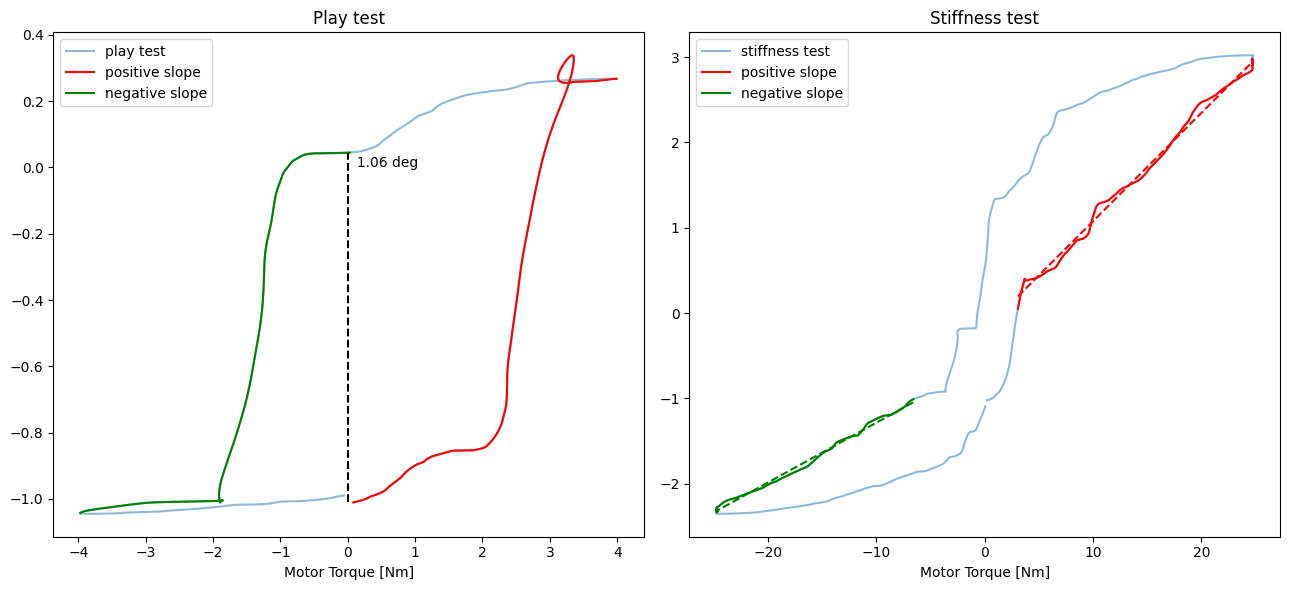

In [60]:
play_test_mean, stiffness_test_mean = tests_split_pccf.torque_ramps['initial'][2]

def get_rising_slopes(df):
    # split data in to positive and negative slopes. remove the hysteresis part
    max_torque_idx = df['Desired Torque [Nm]'].idxmax()
    pos_slope = df.loc[:max_torque_idx]

    # find zero crossing of desired torque
    min_torque_idx = df['Desired Torque [Nm]'].idxmin()
    zero_torque_idx = df['Desired Torque [Nm]'][max_torque_idx:min_torque_idx].abs().idxmin()
    neg_slope = df.loc[zero_torque_idx:min_torque_idx]

    return pos_slope, neg_slope


# estimate play
play_pos_slope, play_neg_slope = get_rising_slopes(play_test_mean)
pos_play = play_pos_slope['Deflection [deg]'].iloc[0]
neg_play = play_neg_slope['Deflection [deg]'].iloc[0]
print(f'Play: {neg_play-pos_play} deg ({pos_play} pos, {neg_play} neg)')


# estimate stiffness
stiffness_pos_slope, stiffness_neg_slope = get_rising_slopes(stiffness_test_mean)
stiffness_pos_slope = stiffness_pos_slope[stiffness_pos_slope['Deflection [deg]'] > neg_play]
stiffness_neg_slope = stiffness_neg_slope[stiffness_neg_slope['Deflection [deg]'] < pos_play]

# do polyfit
pos_stifness, pos_offset = np.polyfit(stiffness_pos_slope['Motor Torque [Nm]'], stiffness_pos_slope['Deflection [deg]'], 1)
neg_stifness, neg_offset  = np.polyfit(stiffness_neg_slope['Motor Torque [Nm]'], stiffness_neg_slope['Deflection [deg]'], 1)

print(f'Positive stiffness: {pos_stifness} deg/Nm, offset: {pos_offset} deg')
print(f'Negative stiffness: {neg_stifness} deg/Nm, offset: {neg_offset} deg')


fig, axs = plt.subplots(1, 2, figsize=(13, 6))
play_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='play test', alpha=0.5)
play_pos_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='positive slope', color='r')
play_neg_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='negative slope', color='g')
# add line to show play
axs[0].plot([0, 0], [pos_play, neg_play], color='black', linestyle='--')
axs[0].text(0, 0, f'  {neg_play-pos_play:.2f} deg', color='black')
axs[0].set_title('Play test')

stiffness_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='stiffness test', alpha=0.5)
stiffness_pos_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='positive slope', color='r')
stiffness_neg_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='negative slope', color='g')
axs[1].plot(stiffness_pos_slope['Motor Torque [Nm]'], pos_offset + pos_stifness*stiffness_pos_slope['Motor Torque [Nm]'], color='r', linestyle='--')
axs[1].plot(stiffness_neg_slope['Motor Torque [Nm]'], neg_offset + neg_stifness*stiffness_neg_slope['Motor Torque [Nm]'], color='g', linestyle='--')
axs[1].set_title('Stiffness test')

fig.tight_layout()
# fig.savefig(f'{filename}_results.png')
plt.show()



Estimated friction for :
coulomb: 3.00474[Nm], (3.57024, -2.43923)
viscous: 0.83305 [Nm/(rev/s)], (0.55458, 1.11152)


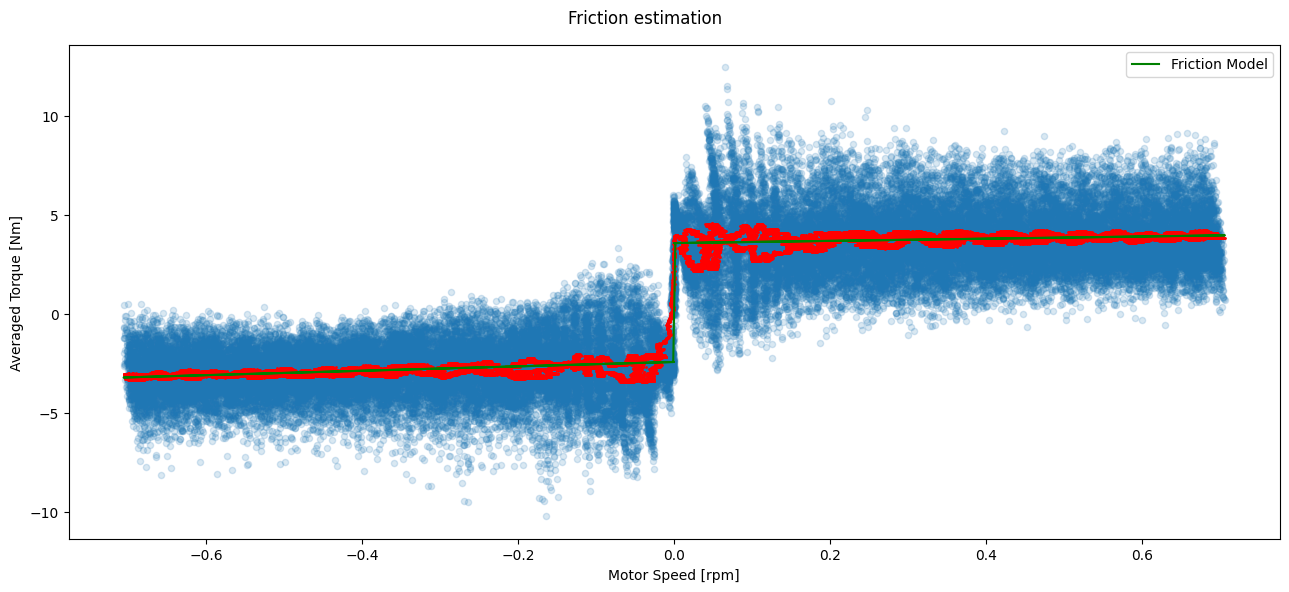

In [57]:

def estimate_friction(df):
    # split data in positive and negative velocity
    positive_vt = df[df['Motor Speed [rpm]'] > 0]
    negative_vt = df[df['Motor Speed [rpm]'] < 0]

    # fit linear model
    pos_viscous, pos_coulomb,  = np.polyfit(positive_vt['Motor Speed [rpm]'], positive_vt['Motor Torque [Nm]'], 1)
    neg_viscous, neg_coulomb,  = np.polyfit(negative_vt['Motor Speed [rpm]'], negative_vt['Motor Torque [Nm]'], 1)

    # average
    coulomb = (pos_coulomb - neg_coulomb) / 2
    viscous = (pos_viscous + neg_viscous) / 2
    print(f'coulomb: {coulomb:.5f}[Nm], ({pos_coulomb:.5f}, {neg_coulomb:.5f})')
    print(f'viscous: {viscous:.5f} [Nm/(rev/s)], ({pos_viscous:.5f}, {neg_viscous:.5f})')

    #create model lines for pos and neg seperately
    pos_model = positive_vt.copy()
    pos_model['Friction Model'] = pos_viscous * pos_model['Motor Speed [rpm]'] + pos_coulomb
    neg_model = negative_vt.copy()
    neg_model['Friction Model'] = neg_viscous * neg_model['Motor Speed [rpm]'] + neg_coulomb

    # combine the two models
    fric_model = pd.concat([neg_model, pos_model])

    return fric_model

def average_data(df, groupby):
    data = []
    grouped = df.groupby(groupby)

    for name, group in grouped:
        group = group.drop(groupby, axis=1)
        group.index = group.index - group.index[0]

        old_len = len(group)
        group = group.resample('0.1ms').mean()
        group = group.interpolate(method='time')
        print(f'group {name} resampled from {old_len} to {len(group)} samples')

        data.append(group.values)

        if len(data) > 100:
            break

    data = data[5:100]

    # get consistent length
    min_len = min([len(d) for d in data])
    data = [d[:min_len] for d in data]
    print(f'setting everything to {min_len} samples')

    # average data using numpy
    data_mean = np.mean(np.array(data), axis=0)

    new_columns = df.columns.drop(groupby)
    mean_df = pd.DataFrame(data_mean, columns=new_columns)

    # smooth data
    mean_df = mean_df.rolling(window=100, center=True).mean()
    mean_df = mean_df.bfill().ffill()

    return mean_df


df = tests_split_pccf.speed_ramps['initial']

# plot measurements
fig, axs = plt.subplots(1, 1, figsize=(13, 6))
axs = [axs]

df.plot(x='Motor Speed [rpm]', y='Motor Torque [Nm]', kind='scatter', alpha=0.17, ax=axs[0])
df.plot(x='Motor Speed [rpm]', y='Averaged Torque [Nm]', kind='scatter', color='red', ax=axs[0], s=1)

# plot estimated friction
print(f'Estimated friction for :')
fric_model = estimate_friction(df)
fric_model.plot(x='Motor Speed [rpm]', y='Friction Model', color='green', ax=axs[0])

# # plot torque over position 
# df['REVOLUTIONS'] = np.floor(df['POSITION'])
# df['POSITION'] = df['POSITION'] - df['REVOLUTIONS']

# n_plots = int(df['REVOLUTIONS'].max())
# colors = plt.cm.viridis(np.linspace(0, 1, n_plots))
# for i in range(0, n_plots):
#     rev = df[(df['REVOLUTIONS'] == i) & (df['Motor Speed [rpm]'] > 0)]
#     rev.plot(x='POSITION', y='Motor Torque [Nm]', ax=axs[1], color=colors[i], alpha=0.4, legend=False)

# avg_fric = average_data(df, 'REVOLUTIONS')
# avg_fric.plot(x='POSITION', y='Motor Torque [Nm]', color='red', ax=axs[1])

fig.suptitle('Friction estimation')
fig.tight_layout()
    
plt.show()

In [58]:
def estimate_friction(df):
    # split data in positive and negative velocity
    positive_vt = df[df['Motor Speed [rpm]'] > 0]
    negative_vt = df[df['Motor Speed [rpm]'] < 0]

    # fit linear model
    pos_viscous, pos_coulomb,  = np.polyfit(positive_vt['Motor Speed [rpm]'], positive_vt['Motor Torque [Nm]'], 1)
    neg_viscous, neg_coulomb,  = np.polyfit(negative_vt['Motor Speed [rpm]'], negative_vt['Motor Torque [Nm]'], 1)

    # average
    coulomb = (pos_coulomb - neg_coulomb) / 2
    viscous = (pos_viscous + neg_viscous) / 2
    print(f'coulomb: {coulomb:.5f}[Nm], ({pos_coulomb:.5f}, {neg_coulomb:.5f})')
    print(f'viscous: {viscous:.5f} [Nm/(rev/s)], ({pos_viscous:.5f}, {neg_viscous:.5f})')

    return viscous, coulomb

def estimate_play_and_stiffness(df):
    def get_rising_slopes(df):
        # split data in to positive and negative slopes. remove the hysteresis part
        max_torque_idx = df['Desired Torque [Nm]'].idxmax()
        pos_slope = df.loc[:max_torque_idx]

        # find zero crossing of desired torque
        min_torque_idx = df['Desired Torque [Nm]'].idxmin()
        zero_torque_idx = df['Desired Torque [Nm]'][max_torque_idx:min_torque_idx].abs().idxmin()
        neg_slope = df.loc[zero_torque_idx:min_torque_idx]

        return pos_slope, neg_slope

    # estimate play
    play_pos_slope, play_neg_slope = get_rising_slopes(df)
    pos_play = play_pos_slope['Deflection [deg]'].iloc[0]
    neg_play = play_neg_slope['Deflection [deg]'].iloc[0]
    play = neg_play - pos_play
    print(f'Play: {play} deg ({pos_play} pos, {neg_play} neg)')

    # estimate stiffness
    stiffness_pos_slope, stiffness_neg_slope = get_rising_slopes(df)
    stiffness_pos_slope = stiffness_pos_slope[stiffness_pos_slope['Deflection [deg]'] > neg_play]
    stiffness_neg_slope = stiffness_neg_slope[stiffness_neg_slope['Deflection [deg]'] < pos_play]

    # do polyfit
    pos_stiffness, pos_offset = np.polyfit(stiffness_pos_slope['Motor Torque [Nm]'], stiffness_pos_slope['Deflection [deg]'], 1)
    neg_stiffness, neg_offset = np.polyfit(stiffness_neg_slope['Motor Torque [Nm]'], stiffness_neg_slope['Deflection [deg]'], 1)

    print(f'Positive stiffness: {pos_stiffness} deg/Nm, offset: {pos_offset} deg')
    print(f'Negative stiffness: {neg_stiffness} deg/Nm, offset: {neg_offset} deg')

    return play, pos_stiffness, neg_stiffness


actuators = [tests_split_pccf, tests_base_pccf, tests_conic_pccf]

for actuator in actuators:
    print(f'\n\n{actuator.configuration}')
    for name, ramps in actuator.torque_ramps.items():
        print(f'\n{name}')
        for i, (play_test_mean, stiffness_test_mean) in enumerate(ramps):
            print(f'  Test {i+1}')
            play, pos_stiffness, neg_stiffness = estimate_play_and_stiffness(play_test_mean)
            viscous, coulomb = estimate_friction(actuator.speed_ramps[name])
            print(f'  Friction: viscous: {viscous:.5f} [Nm/(rev/s)], coulomb: {coulomb:.5f} [Nm]')



Split Pinwheel (PC-CF)

initial
  Test 1
Play: 1.1747057958330427 deg (-0.9288409264174095 pos, 0.24586486941563318 neg)
Positive stiffness: 0.10881975763859504 deg/Nm, offset: 0.40362528966517647 deg
Negative stiffness: 0.7477782890886774 deg/Nm, offset: 2.107428612993749 deg
coulomb: 3.00474[Nm], (3.57024, -2.43923)
viscous: 0.83305 [Nm/(rev/s)], (0.55458, 1.11152)
  Friction: viscous: 0.83305 [Nm/(rev/s)], coulomb: 3.00474 [Nm]
  Test 2
Play: 0.5203260726928711 deg (-0.19909094474699424 pos, 0.32123512794587683 neg)


TypeError: expected non-empty vector for x